In [29]:
import numpy as np
import scipy.optimize as opt
import statistic_tools.general as st
import inspect

import matplotlib.pyplot as plt

In [85]:
def chi_square_cost(args, f, xdata, ydata, sigma):
    return sum([(f(x, *args) - y)**2/(s**2) for x,y,s in zip(xdata, ydata, sigma)])


def chi_square_single(f, xdata, ydata, sigma, fargs0):
    sol = opt.minimize(chi_square_cost, fargs0, args=(f, xdata, ydata, sigma), tol=1e-6, method='BFGS')
    dof = xdata.shape[0] - len(fargs0)
    return sol.x, sol.fun/dof

def create_pseudo_samples(ydata, yerr):
    psample = np.zeros_like(ydata)
    for i, y in enumerate(ydata):
        psample[i] = y + np.random.normal(loc=0.0, scale=yerr[i])
    return psample

def chi_square(f, xdata, ydata, yerr, fargs0=[], Nsample=1):
    if xdata.shape != ydata.shape:
        raise ValueError()
    
    if yerr.shape != xdata.shape:
        raise ValueError()
        
    if len(fargs0) == 0:
        nargs = len(str(inspect.signature(f)).split(','))-1
        fargs0 = np.random.uniform(0, 1, size=(nargs,))
    
    args = np.zeros((Nsample, nargs), dtype=np.double)
    redchi2vals = np.zeros((Nsample, ), dtype=np.double)
    
    args[0], redchi2vals[0] = chi_square_single(f, xdata, ydata, yerr, fargs0)
    
    for i in range(1, Nsample):
        pydata = create_pseudo_samples(ydata, yerr)
        args[i], redchi2vals[i] = chi_square_single(f, xdata, pydata, yerr, fargs0)
        
    if Nsample > 1:
        args = st.bootstrap(args)
        redchi2vals = st.bootstrap(redchi2vals)
    else:
        args = (args[0], np.zeros_like(args)), (redchi2vals[0], 0.0)
        
    return args, redchi2vals
    
    
    
    
    
        
        
        
        
    


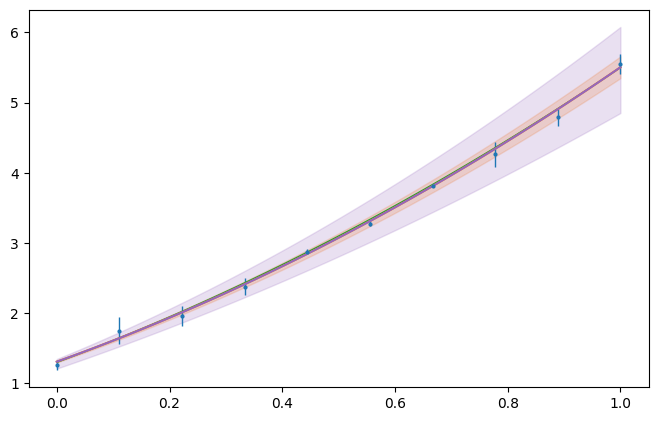

In [104]:
def f0(x, a, b, c):
    return a + b * x + c * x**2

avals_true = [1.3, 3.0, 1.2]

x = np.linspace(0, 1, 100)
ytrue = f0(x, *avals_true)

np.random.seed(42)

N = 10
xdata = np.linspace(0, 1, 10)
sigmas = np.random.uniform(0,0.2,size=10)
ydata = f0(xdata, *avals_true) + np.array([np.random.normal(loc=0.0, scale=s) for s in sigmas])

fig = plt.figure(dpi=100, figsize=(8,5))
plt.errorbar(xdata, ydata, yerr=sigmas, marker='o', ms=2, lw=1, ls='')
plt.plot(x, ytrue, lw=1, color='tab:green', label='true curve')

args, redchi2 = chi_square(f0, xdata, ydata, sigmas, Nsample=20)

popt = args[0]
perr = args[1]
chi2 = redchi2[0]
chi2err = redchi2[1]

plt.plot(x, f0(x, *popt), color='tab:orange')
plt.fill_between(x, f0(x, *(popt+perr)), f0(x, *(popt-perr)), alpha=0.2, color='tab:orange')

popt_ref, pcov_ref = opt.curve_fit(f0, xdata, ydata, sigma=sigmas, absolute_sigma=True)
perr_ref = np.sqrt(np.diag(pcov_ref))
plt.plot(x, f0(x, *popt), color='tab:purple')
plt.fill_between(x, f0(x, *(popt_ref+perr_ref)), f0(x, *(popt_ref-perr_ref)), alpha=0.2, color='tab:purple')


[  0.00 s] Nsample = 2
[  0.06 s] Nsample = 3
[  0.09 s] Nsample = 4
[  0.17 s] Nsample = 5
[  0.25 s] Nsample = 6
[  0.34 s] Nsample = 7
[  0.42 s] Nsample = 8
[  0.55 s] Nsample = 9
[  0.65 s] Nsample = 10
[  0.77 s] Nsample = 11
[  0.91 s] Nsample = 12
[  1.07 s] Nsample = 13
[  1.30 s] Nsample = 14
[  1.46 s] Nsample = 15
[  1.68 s] Nsample = 16
[  1.93 s] Nsample = 17
[  2.20 s] Nsample = 18
[  2.40 s] Nsample = 19
[  2.66 s] Nsample = 20
[  2.92 s] Nsample = 21
[  3.20 s] Nsample = 22
[  3.48 s] Nsample = 23
[  3.76 s] Nsample = 24
[  4.13 s] Nsample = 25
[  4.38 s] Nsample = 26
[  4.79 s] Nsample = 27
[  5.17 s] Nsample = 28
[  5.58 s] Nsample = 29
[  5.97 s] Nsample = 30
[  6.40 s] Nsample = 31
[  6.81 s] Nsample = 32
[  7.21 s] Nsample = 33
[  7.68 s] Nsample = 34
[  8.19 s] Nsample = 35
[  8.53 s] Nsample = 36
[  8.98 s] Nsample = 37
[  9.43 s] Nsample = 38
[ 10.00 s] Nsample = 39
[ 10.50 s] Nsample = 40
[ 10.98 s] Nsample = 41
[ 11.44 s] Nsample = 42
[ 12.05 s] Nsample = 43


No handles with labels found to put in legend.
No handles with labels found to put in legend.


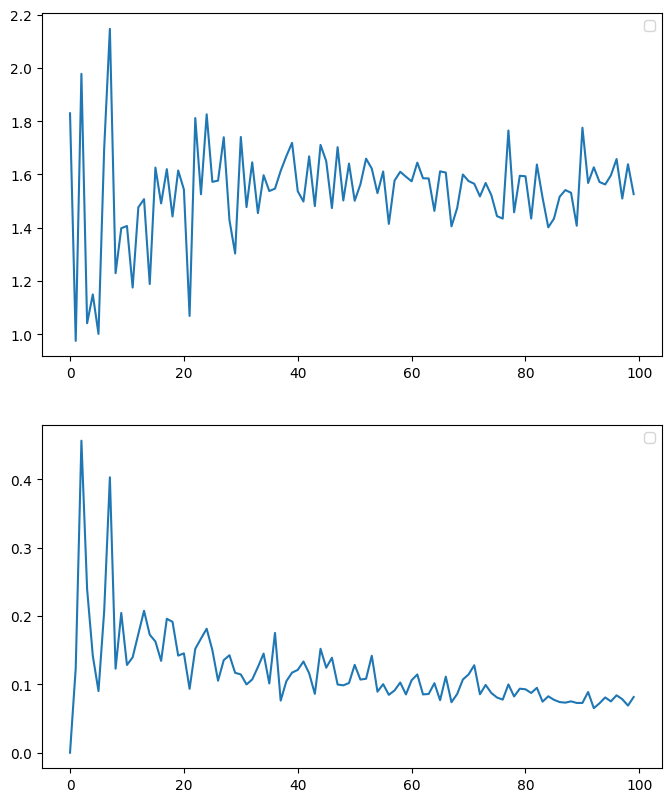

In [105]:
import time

Ntotal = 100

vals = np.zeros((Ntotal, 3), dtype=np.double)
errs = np.zeros((Ntotal, 3), dtype=np.double)

chi2s = np.zeros((Ntotal,2),dtype=np.double)
t_start = time.time()
for i in range(0, Ntotal):
    print(f'[{time.time() - t_start:6.2f} s] Nsample = {i+2}')
    args, redchi2 = chi_square(f0, xdata, ydata, sigmas, Nsample=i+2)
    vals[i,:] = args[0]
    errs[i,:] = args[1]
    chi2s[i,:] = redchi2
    
    
fig, axes = plt.subplots(2, 1, dpi=100, figsize=(8,10))

axes[0].plot(chi2s[:,0])
axes[1].plot(chi2s[:,1])
for ax in axes:
    ax.legend()
plt.show()